<h1>1- Definição de conceitos</h1> 

<h2>1.1- O que é a Baixa Pombalina para efeitos deste problema? </h2> 


A Baixa Pombalina, no âmbito deste problema, é a área delimitada onde iremos quantificar o número de cafés existentes.


A API TomTom permite georreferenciar uma zona através de vários métodos, incluindo:

<ul>
    <li>Definição de um raio: Se os parâmetros <code>radius</code> e <code>position</code> forem definidos, os resultados serão limitados à área especificada.</li>
    <li>Bounding box: Utilizando os parâmetros <code>topLeft</code> (canto superior esquerdo) e <code>btmRight</code> (canto inferior direito) para delimitar uma área retangular.</li>
    <li>Definição de um retângulo com <code>geobias</code>: Utiliza o parâmetro <code>geobias</code> para indicar uma preferência de localização num retângulo, influenciando a ordenação dos resultados, mas sem filtrar rigidamente.</li>
    <li>Definição de um polígono: Através da do serviço api <code>geometry search</code>, é possível marcar vários pontos para definir um polígono personalizado que limita os resultados à área geográfica especificada.</li>
</ul>

Ao pesquisar "Baixa Pombalina" na Wikipédia, encontrei a seguinte  representação geográfica representada na imagem abaixo. 

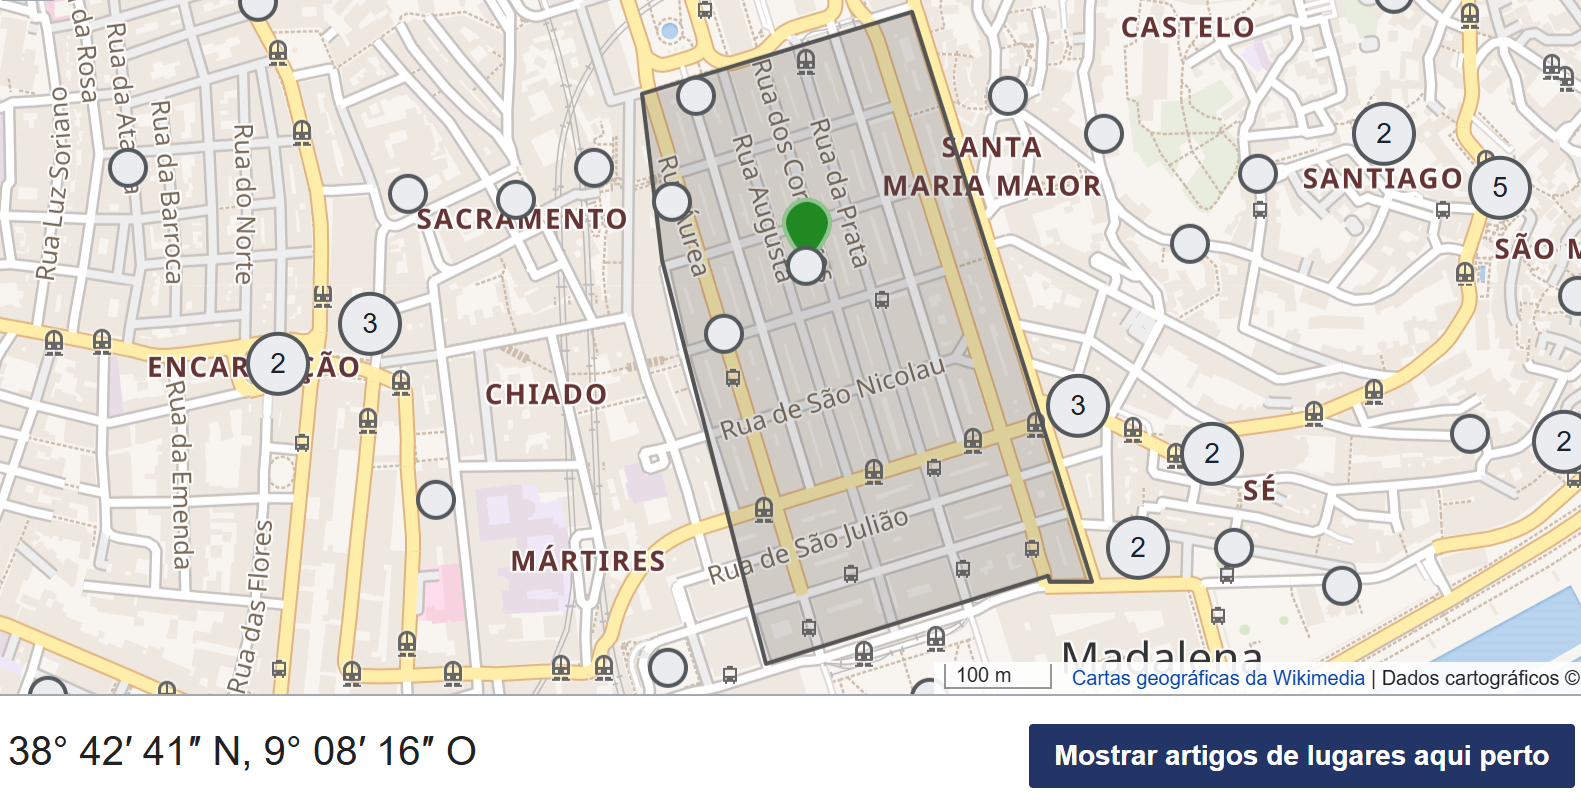


Tendo em conta que a representação acima se enquadra num polígono irregular, decidi definir a área em análise geográfica através de um polígono personalizado composto por vários vértices.

Através do site geojson.io, foram marcados vários pontos com o objetivo de definir a área do polígono representada no artigo da Wikipédia. O site permite exportar a lista de coordenadas registadas em diferentes formatos; neste caso, foi escolhido o formato CSV. O ficheiro gerado será utilizado para criar o payload do serviço GeometrySearch, no qual é passado, no seu conteúdo, um polígono com os respetivos vértices.

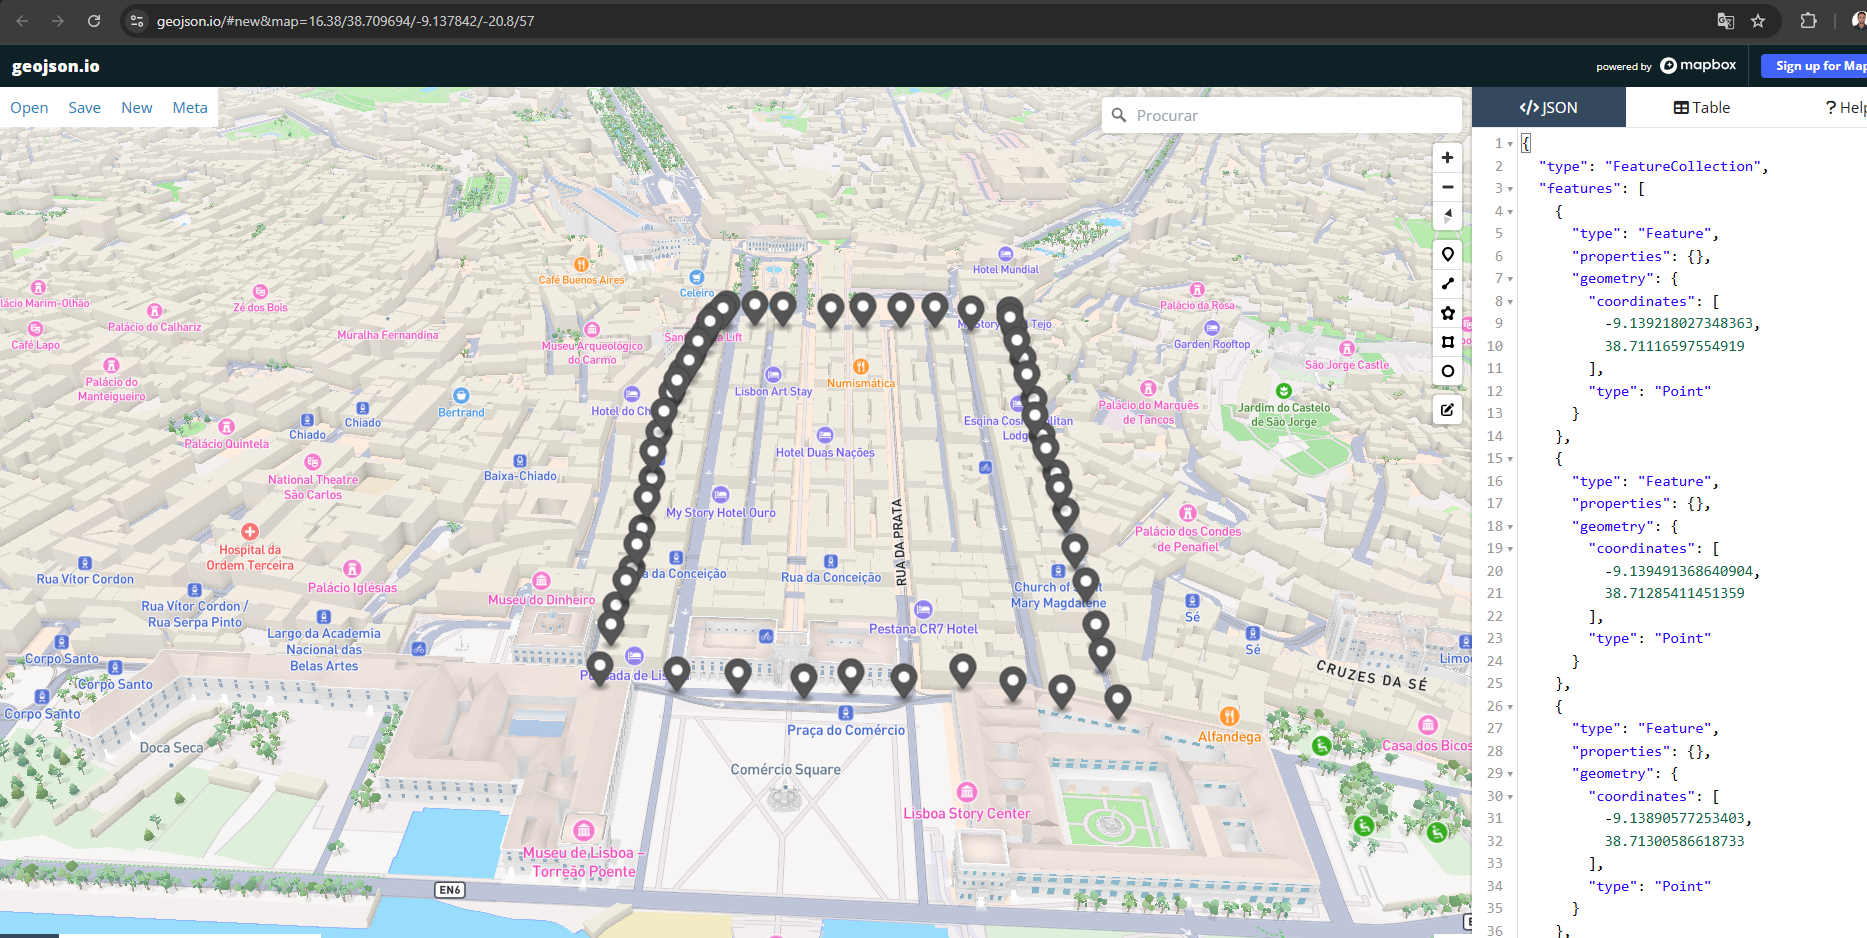


<h2>1.2- O que é uma café para efeitos deste problema?</h2> 

Para efeitos deste problema, um "café" será considerado qualquer estabelecimento comercial identificado na API TomTom como um local destinado ao consumo de café, excluindo restaurantes, que normalmente estão vocacionados para servir refeições completas. Os estabelecimentos considerados incluem:

<ul>
    <li>Cafetarias</li>
    <li>Pastelarias</li>
    <li>Espaços que ofereçam serviços de café</li>
    <li>Outros locais destinados a pequeno-almoço ou lanches</li>
</ul>


A API TomTom oferece um serviço denominado "category-search", que retorna uma lista de IDs das categorias de pontos de interesse disponíveis para pesquisa nos seus serviços. Com base neste serviço, foi definido um conjunto de palavras-chave para incluir ou excluir categorias devolvidas, caso estas contivessem essas palavras no respetivo nome ou na propriedade de sinónimos. Assim, foi criada uma lista de categorias que se enquadram como pontos de interesse do tipo "café".

<table border="1">
    <thead>
        <tr>
            <th>Palavras-Chave</th>
            <th>Palavras-Chave Exclusão</th>
        </tr>
    </thead>
    <tbody>
        <tr><td>Café</td><td>restaurant</td></tr>
        <tr><td>Coffee</td><td>wine bar</td></tr>
        <tr><td>Bakery</td></tr>
        <tr><td>Cafe</td></tr>
        <tr><td>Cafeteria</td></tr>
        <tr><td>Breakfast</td></tr>
        <tr><td>Snack</td></tr>
        <tr><td>Tea</td></tr>
        <tr><td>Pastry</td></tr>
        <tr><td>Lounge</td></tr>
        <tr><td>Doughnut</td></tr>
        <tr><td>Dessert</td></tr>
        <tr><td>Bistro</td></tr>
        <tr><td>Espresso</td></tr>
        <tr><td>Bar</td></tr>
    </tbody>
</table>


<h1>2- Implementação</h1>

<h2>Importação de Livrarias</h2>

In [30]:
import requests
import pandas as pd
import json
import csv
import folium
from IPython.display import display
import uuid
import seaborn as sns
import numpy as np

<h2>Constantes</h2>

In [2]:
API_KEY = ""
MAX_CATEGORIES = 10
LIMIT_RECORDS_API = 100
KEYWORD_FILE = "data/keywords_list.csv"
PAYLOAD_POLYGON_FILE = "logs/payload_polygon_vertices.txt"
CATEGORY_ID_FILE = "data/categories_id.csv"
COORDINATES_FILE = "data/input_coordinates.csv"
SAVE_LOG_APIS = True

<h2>2.1- Obter Lista de Categorias onde se incluem os pontos de Interesse</h2>

Esta função é responsável por ler a lista de palavras-chave para incluir ou excluir categorias, definida no ficheiro CSV "keywords_list.csv", e criar listas com os respetivos conteúdos.

In [3]:
# Esta função lê lista de palavras-chave a incluir/excluir na consulta de categorias da API de Categorias TomTom
def process_keywords(input_file):
    try:
        keywords = []
        exclude_keywords = []

        # Ler o ficheiro CSV
        with open(input_file, mode='r', encoding="utf-8") as file:
            reader = csv.reader(file)
            next(reader)  # Ignorar o cabeçalho
            for row in reader:
                if len(row) >= 2:  # Certificar que existem pelo menos duas colunas
                    if len(row[0]) > 1:
                        keywords.append(row[0].strip())
                    if len(row[1]) > 1:
                        exclude_keywords.append(row[1].strip())

        return keywords, exclude_keywords
    except FileNotFoundError:
        print(f"Erro: O ficheiro '{input_file}' não foi encontrado.")
    except Exception as e:
        print(f"Ocorreu um erro ao processar o ficheiro: {e}")


input_file = KEYWORD_FILE
keywords, exclude_keywords = process_keywords(input_file)

print(keywords)
print(exclude_keywords)


['Café', 'Coffee', 'Bakery', 'Cafe', 'Cafeteria', 'Breakfast', 'Snack', 'Tea', 'Pastry', 'Lounge', 'Doughnut', 'Dessert', 'Bistro', 'Espresso', 'Bar']
['restaurant', 'barracks', 'nails', 'plateau', 'wine bar', 'Cabaret', 'guesthouse', 'hotel', 'hostel']



O código abaixo implementa chamada à  API **TomTom poiCategories**, que permite extrair informações das categorias possíveis de pontos de interesse. O conteúdo devolvido pela API é verificado para garantir que cumpre as regras das palavras-chave definidas no ponto anterior. O conteúdo validado é, então, guardado num ficheiro CSV.

### `fetch_and_process_category_api`

- **Parâmetros**:
  - `url`: url da API.
  - `params`: Dicionário com parametros necessários à invocação da API, nesse caso a chave de acesso.
  - `keywords`: Conjunto de palavras chaves a ter em consideração a seleção da categoria
  - `exclude_keywords`: Conjunto de palavras chaves a ter em consideração a não seleção da categoria

- **Fluxo**:
  1. Define os parâmetros da requisição HTTP.
  2. Envia a requisição `GET` para a API.
  3. Retorna a resposta em formato JSON, se a chamada for bem-sucedida.
  4. Em caso de erro, imprime o código de status e a mensagem de erro.

---

In [4]:
# Endereço Api Categorias Possiveis de Pontos de Interesse
url = "https://api.tomtom.com/search/2/poiCategories.json"
params = {
    "key": API_KEY  
}


def fetch_and_process_category_api(url, params, keywords, exclude_keywords):
    try:
        # Chamada à API
        response = requests.get(url, params=params)

        # Verificar se request bem-sucedido
        if response.status_code == 200:
            data = response.json()  # Obter a resposta em formato JSON

            # Extrair categorias
            categories = data.get("poiCategories", [])

            # Extrair conteúdo: ids, nomes e sinônimos
            extracted_data = []
            for category in categories:

                # Combinar nome e sinônimos numa única string para pesquisa
                name_synonim_text = category.get("name", "").lower() + " " + " ".join(category.get("synonyms", [])).lower()
                if any(keyword.lower() in name_synonim_text for keyword in keywords) and not any(exclude_keyword.lower() in name_synonim_text for exclude_keyword in exclude_keywords):
                    accepted_category = {
                        "id": category.get("id"),
                        "name": category.get("name"),
                        "synonyms": category.get("synonyms", [])
                    }
                    extracted_data.append(accepted_category)

            # Criar o dataframe
            df = pd.DataFrame(extracted_data)

            if not df.empty:
                print(df)

                # Guardar informação de categorias num ficheiro CSV
                df.to_csv("data/categories_id.csv",sep=";", index=False)

                ids_Categorias = ";".join(map(str, df['id'].unique()))
                return ids_Categorias
            else:
                print("Nenhum dado foi extraído das categorias.")
                return None
        else:
            print(f"Erro na chamada da API: {response.status_code}")
            return None
    except requests.RequestException as re:
        print(f"Erro na requisição: {re}")
    except KeyError as ke:
        print(f"Erro ao acessar dados da resposta: {ke}")
    except ValueError as ve:
        print(f"Erro ao converter dados JSON: {ve}")
    except Exception as e:
        print(f"Ocorreu um erro inesperado: {e}")

# Chamada à função
ids_Categorias = fetch_and_process_category_api(url, params, keywords, exclude_keywords)
print(ids_Categorias)
 

         id              name  \
0      9376          Café/Pub   
1   9379004               Bar   
2   7315007            Bistro   
3   9376002              Café   
4   7315147         Cafeteria   
5   9379006      Cocktail Bar   
6   9376006       Coffee Shop   
7   9379009       Comedy Club   
8   9361018            Bakery   
9   9376004     Internet Café   
10  9379008         Jazz Club   
11  9379010      Karaoke Club   
12  7315039          Pub Food   
13  7315143         Salad Bar   
14  9376005         Tea House   
15  7315149  Yogurt/Juice Bar   
16     7358        Truck Stop   
17     7375         Toll Gate   

                                             synonyms  
0                                                  []  
1                                                  []  
2                                                  []  
3                                              [Cafe]  
4                                         [Cafetaria]  
5                               [Coc

<h2>2.2- Extração de informação dos pontos de interesse, incluídos na lista de categorias definidas no passo anterior, respeitando área geográfica delimitada através da Api GeometrySearch</h2>

<h3>2.2.1- Construção do Payload necessário no consumo da Api GeometrySearch </h3>

Esta função é responsável por extrair os pontos de latitude e longitude incluídos no ficheiro CSV gerado pelo site geojson.io e incorporar essa informação no formato de payload, onde são definidos os vértices do polígono necessário para a solicitação de pontos de interesse na área de interesse através da API GeometrySearch

In [5]:
def csv_coordinates_to_polygon(input_file_path, output_file_path):
    # Ler as coordenadas do ficheiro CSV
    coordinates = []
    with open(input_file_path, 'r') as csv_file:
        reader = csv.reader(csv_file)
        next(reader)  # Ignorar o cabeçalho (lon,lat)
        for row in reader:
            lon, lat = map(float, row)  # Convertendo para floats
            coordinates.append([lat, lon])

    # Garantir que o polígono é fechado
    if coordinates[0] != coordinates[-1]:
        coordinates.append(coordinates[0])


    # Criar o payload no formato esperado
    polygon_data = {
        "geometryList": [
            {
                "type": "POLYGON",
                "vertices": [
                    f"{lat},{lon}" for lat, lon in coordinates
                ]
            }
        ]
    }

    # Guardar o JSON resultante no ficheiro de saída
    with open(output_file_path, 'w') as output_file:
        json.dump(polygon_data, output_file, indent=2)

    print(f"Ficheiro criado: {output_file_path}")
    return polygon_data


# Chamada à função
payload_geometry_search= csv_coordinates_to_polygon(COORDINATES_FILE,PAYLOAD_POLYGON_FILE)

Ficheiro criado: logs/payload_polygon_vertices.txt


<h3>2.2.2- Obter  pontos de Interesse através da Api GeometrySearch</h3>

A API Geometry Search permite passar como parâmetro uma lista dos IDs das categorias de pontos de interesse para as quais pretendemos obter informação. Tendo em conta que a API tem uma limitação de apenas permitir o envio de, no máximo, 10 categorias por pedido, foi definido este valor máximo a ser respeitado em cada pedido. Caso a lista de categorias exceda o valor máximo permitido, o processo deverá subdividr o pedido à API em vários pedidos, respeitando o limite máximo de categorias por pedido. 

A função split_categories divide a lista de categorias em novas listas respeitando o limite máximo de categorias por pedido.

In [6]:
def split_categories(category_set, max_categories):
    categories = category_set.split(";")
    return [categories[i:i + max_categories] for i in range(0, len(categories), max_categories)]

category_batches = split_categories(ids_Categorias, MAX_CATEGORIES)
print(category_batches)

[['9376', '9379004', '7315007', '9376002', '7315147', '9379006', '9376006', '9379009', '9361018', '9376004'], ['9379008', '9379010', '7315039', '7315143', '9376005', '7315149', '7358', '7375']]


O código abaixo implementa chamada à  API **TomTom Geometry Search**, que permite pesquisar pontos de interesse (POIs) dentro de uma área geográfica definida. 

### `call_geometry_search`

- **Parâmetros**:
  - `api_key`: Chave de autenticação para a API.
  - `category_set`: Conjunto de categorias de pontos de interesse (POIs) a serem pesquisadas.
  - `geometry_list`: Lista de coordenadas dos vertices do poligono que define a area geográfica da análise
  - `offset`: Posição inicial para paginação dos resultados (valor padrão: 0).
- **Fluxo**:
  1. Define os parâmetros e o corpo da requisição HTTP.
  2. Envia a requisição `POST` para a API.
  3. Retorna a resposta em formato JSON, se a chamada for bem-sucedida.
  4. Em caso de erro, imprime o código de status e a mensagem de erro.

---



In [7]:
def call_geometry_search(api_key, category_set, geometry_list, offset=0):
    try:
        # URL da API
        url = "https://api.tomtom.com/search/2/geometrySearch/.json"

        # Parâmetros da API
        params = {
            "key": api_key,
            "categorySet": category_set,
            "limit": LIMIT_RECORDS_API,
            "offset": offset
        }

        # Body Payload
        body = geometry_list

        # Realizar a chamada à API
        response = requests.post(url, params=params, json=body)

        # Verificar o status da resposta
        if response.status_code == 200:
            return response.json()
        else:
            print(f"Erro na chamada à API. Status code: {response.status_code}")
            print("Mensagem de erro:", response.text)
            return None

    except requests.RequestException as e:
        print(f"Erro ao realizar a requisição: {e}")
        return None

### `parse_response_to_dataframe`
Esta função converte os dados da resposta da API para um `DataFrame` da livraria pandas.

- **Parâmetros**:
  - `response`: Resposta JSON da API.
- **Fluxo**:
  1. Itera sobre os resultados retornados pela API.
  2. Extrai informações importantes, como nome, telefone, endereço e posição (latitude e longitude).
  3. Organiza os dados numa estrutura de lista de dicionários.
  4. Retorna um `DataFrame` contendo os dados organizados.

---

In [22]:
def parse_response_to_dataframe(response):
    data = []
    for result in response.get('results', []):
        poi = result.get('poi', {}) 
        address = result.get('address', {})
        poi_name = poi.get('name', '')
        poi_categoryset = [str(category.get('id')) for category in poi.get('categorySet', [])]
        poi_phone = poi.get('phone', '') 
        poi_categories = poi.get('categories', [])  
        poi_street_name = address.get('streetName', '') 
        poi_municipality_subdivision = address.get('municipalitySubdivision', '') 
        poi_postal_code = address.get('postalCode', '') 
        poi_freeform_address = address.get('freeformAddress', '')
        position = result.get('position', {})
        poi_position_lat = position.get('lat', '')
        poi_position_lon = position.get('lon', '')

        data.append({ 
            'name': poi_name, 
            'phone': poi_phone, 
            'address.streetName': poi_street_name, 
            'address.municipalitySubdivision': poi_municipality_subdivision, 
            'address.postalCode': poi_postal_code, 
            'freeformAddress': poi_freeform_address,
            'position_lat': poi_position_lat,
            'position_lon': poi_position_lon, 
            'categoryset': ", ".join(poi_categoryset),
            'categories': ", ".join(poi_categories)
        }) 
    return pd.DataFrame(data)

### `fetch_all_results`
Esta função gere a paginação da API para garantir que todos os resultados são recolhidos. Apesar de ter sido a logica de implementação da paginação através do parametro offset, a api não responde corretamente a este parametro.

- **Parâmetros**:
  - `api_key`: Chave de autenticação para a API.
  - `category_set`: Conjunto de categorias de POIs.
  - `geometry_list`: Lista de geometrias que define as áreas de interesse.
- **Fluxo**:
  1. Inicializa o `offset` e uma lista para armazenar os `DataFrames`.
  2. Realiza chamadas iterativas à API utilizando a função `call_geometry_search`.
  3. Determina o número total de resultados e o número de registos retornados por chamada.
  4. Adiciona os dados retornados a um `DataFrame` e incrementa o `offset` para buscar a próxima página.
  5. Combina todos os `DataFrames` num único `DataFrame` consolidado.

---

In [23]:
def fetch_all_results(api_key, category_set, geometry_list):
    offset = 0
    dataframes = []
    total_results = float('inf')  # Inicialmente desconhecido

    while offset < total_results:
        # Chamar a API com o offset atual
        response = call_geometry_search(api_key, category_set, geometry_list, offset)

        if response:
            # Obter total de resultados e registos retornados
            total_results = response.get('summary', {}).get('totalResults', 0)
            num_results = response.get('summary', {}).get('numResults', 0)

            # Converter resposta para DataFrame
            df = parse_response_to_dataframe(response)
            dataframes.append(df)

            # Incrementar o offset
            offset += num_results

            # Guardar a resposta logst resposta comunicações api 
            if SAVE_LOG_APIS:
                unique_filename = f"response_geometry_search_{uuid.uuid4()}.txt"
                with open("logs/"+unique_filename, "w", encoding="utf-8") as file:
                    json.dump(response, file, ensure_ascii=False, indent=4)

        else:
            print("Erro na resposta da API ou resposta inválida.")
            break

    # Combinar todos os DataFrames num só
    final_df = pd.concat(dataframes, ignore_index=True)
    return final_df

### Fluxo de Execução das funções  anteriores

1. **Iteração por Batch de Categorias**:
   - O código divide as categorias em batches (conjuntos) para respeitar o limite da API de 10 categorias por chamada.
   - Para cada batch, chama a função `fetch_all_results` para obter todos os resultados.

2. **Ordenação e guardar resultados**:
   - O `DataFrame` consolidado é ordenado alfabeticamente pela coluna `poi_name`.
   - O `DataFrame` final é salvo num ficheiro CSV chamado `resultados_pois.csv`.

---

In [26]:
# Exemplo de utilização
dataframes = []
for batch in category_batches:
    batch_category_set = ",".join(batch)
    result_df = fetch_all_results(API_KEY, batch_category_set, payload_geometry_search)
    dataframes.append(result_df)

apidata_df = pd.concat(dataframes, ignore_index=True)

# Guardar log em CSV
apidata_df = apidata_df.sort_values(by='name', ascending=True)

# Reiniciar os índices após a ordenação
apidata_df.reset_index(drop=True, inplace=True)
apidata_df.to_csv('resultados_pois.csv',sep=";", index=False)


<h3>2.2.3- Validar Informação recebida</h3>

...

     name  phone  address.streetName  address.municipalitySubdivision  \
0   False  False               False                            False   
1   False  False               False                            False   
2   False  False               False                            False   
3   False   True               False                            False   
4   False  False               False                            False   
5   False  False               False                            False   
6   False   True               False                            False   
7   False  False               False                            False   
8   False  False               False                            False   
9   False  False               False                            False   
10  False  False               False                            False   
11  False  False               False                            False   
12  False   True               False               

<Axes: >

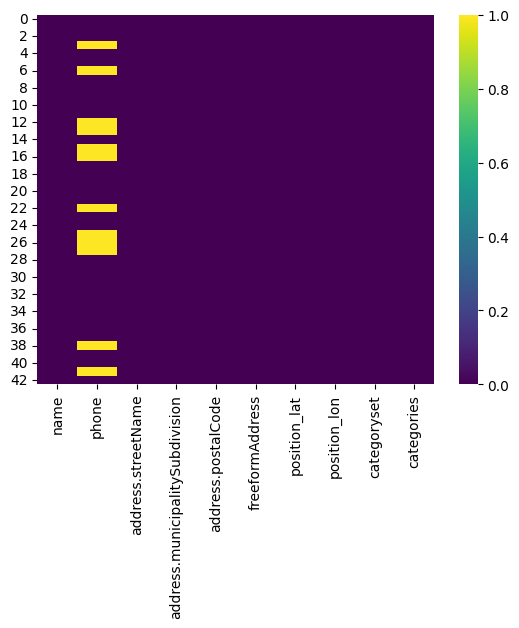

In [31]:
# Analisar primeiras linhas do dataframe
#print(apidata_df.head())

apidata_df = apidata_df.replace("", np.nan)


print(apidata_df.isna())

# Apresentar variaveis com ausência de valores visualmente
sns.heatmap(apidata_df.isna(), cmap='viridis')

<h3>2.2.4- Apresentação dos resultados apurados geograficamente</h3>


O código abaixo representa geograficamente os pontos de interesse identificados através da biblioteca Folium e verifica a sua posição em relação aos limites geográficos definidos na análise. Os pontos de interesse são marcados a azul, enquanto os limites geográficos são destacados com uma linha vermelha.

In [16]:
# Centrar o mapa num ponto através do calculo da média das latitudes/longitudes dos pontos de interesses encontrados.
map = folium.Map(location=[final_df["poi_position_lat"].mean(), final_df["poi_position_lon"].mean()], zoom_start=14)

# Marcar no mapa os pontos de interesse
for _, row in final_df.iterrows():
    folium.Marker(
        location=[row["poi_position_lat"], row["poi_position_lon"]],
        popup=row["poi_name"],
        icon=folium.Icon(color='blue', icon='info-sign')
    ).add_to(map)

# Marcar no mapa  limite geográfico da análise.
df_polygon_vertex = pd.read_csv(COORDINATES_FILE)
folium.PolyLine(
    locations=df_polygon_vertex[["lat", "lon"]].values.tolist(),
    color='red',  # Cor da linha
    weight=10,  
    opacity=0.8  # Transparência
).add_to(map)

map.save("display_poi_vertexpolygon_map.html")

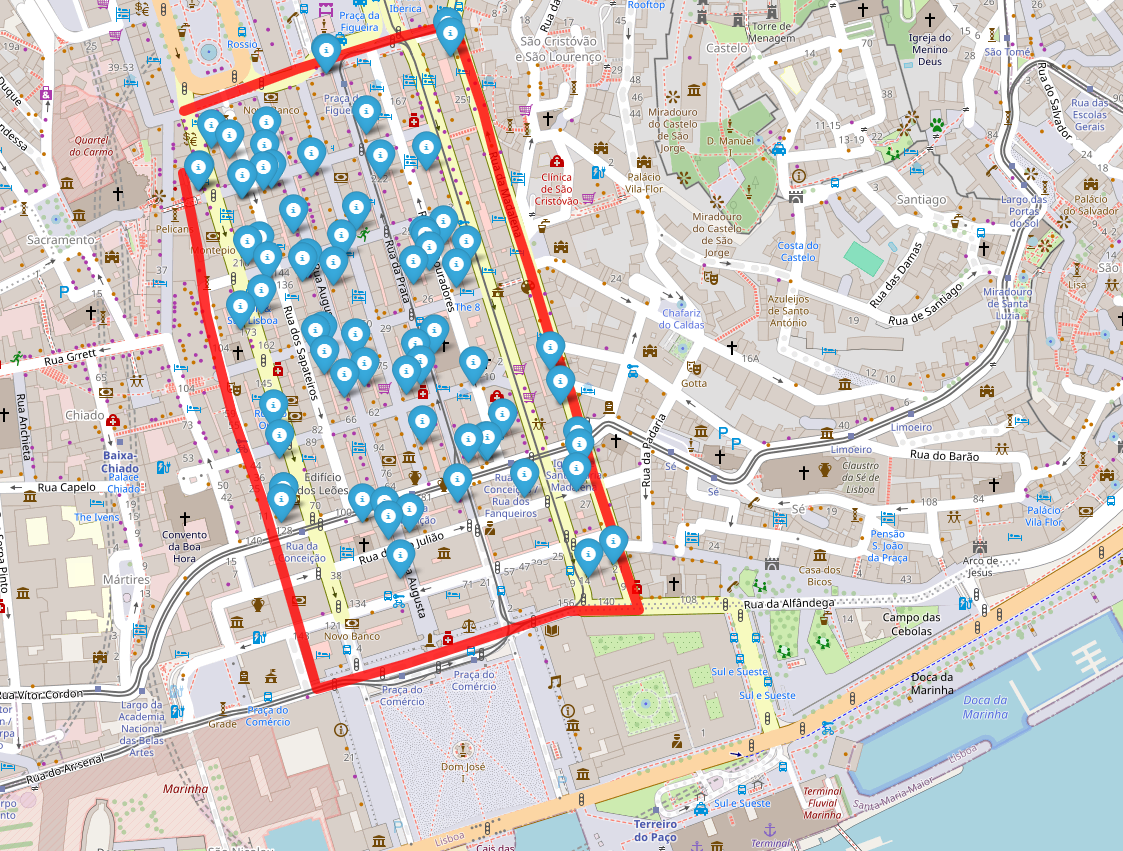